Import all the necessary libraries.

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as st
import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', 100) # let dataframes expand out all columns

Define a couple functions to create dummy variables for the subcategories. Shouldn't need to worry about these too much, they just put 1's under the columns of the subcategories the project falls under and 0's in the columns the project is not classified as.

In [2]:
def splitSubcat(df):
    df = df.copy()
    ext = [np.nan, np.nan]
    results = []
    for row in df['subcat_tree'].iteritems():
        if type(row[1]) is str:
            if ',' in row[1]:
                ext = list(map(lambda x: x.strip(), row[1].split(',')))
            else:
                ext[0] = row[1].strip()
                ext[1] = np.nan

            results.append([ext[0], ext[1]])
        else:
            results.append([np.nan, np.nan])
        
    results = pd.DataFrame(results, columns=['subcat_first', 'subcat_second'], index=df.index)
    print('Finished Splitting...')
    return df.merge(results, right_index=True, left_index=True).drop('subcat_tree', axis=1)

def sumSubcats(df, columns):
    df = df.copy()
    df2 = pd.get_dummies(df, prefix='s', columns=columns)
    cols, col_counts = np.unique(df2.columns.values, return_counts=True)
    for i, col in enumerate(cols):
        if col_counts[i] == 1:
            df[col] = df2[col]
        elif col_counts[i] > 1:
            df[col] = df2[col].sum(axis=1)
    return df

Import all the datasets.

In [3]:
schools_dat = pd.read_csv('data/data_clean/schools_clean.csv')
teachers_dat = pd.read_csv('data/data_clean/teachers_clean.csv')
projects_notext_dat = pd.read_csv('data/data_clean/projects_num_clean.csv')

Take a random sample of $n=10000$ from the projects dataset. Merge this with schools, aligning `school_id`. Get rid of a few columns we don't care about (for the time being). Then create the dummy variables using the functions above.

In [4]:
sample = projects_notext_dat.sample(10000)
merge = sample.merge(teachers_dat, on='teacher_id').merge(schools_dat, on='school_id')
end = merge.drop(['proj_post_seq', 'proj_type', 'funded', 'posted', 'expire', 'first_project_posted'], axis=1)

In [5]:
cat_break = sumSubcats(splitSubcat(end), ['subcat_first', 'subcat_second'])

Finished Splitting...


Basically, clean the dataset so it's only 1's and 0's which we can compare. More info inline.

In [6]:
num_mat = cat_break.select_dtypes(np.number) # use only the numerical columns

num_mat = num_mat[num_mat['prefix'] > 0] # limit teacher prefix to only Mrs. and Mr.
num_mat['prefix'] = num_mat['prefix'] - 1 # reduce teacher prefix to only 1's and 0's

# we'll create four sets of dummy variables
metros = []
grades = []
costs = []
lunches = []
locations = []

num_mat.dropna(inplace=True) # get rid of rows that have one or more null values

for i, row in num_mat.iterrows():
    
    # iterate over each row in the subset thus far, we'll create dummy variables for each select feature
    
    # expand metropolitan type
    res = [0, 0, 0, 0, 0]
    if row['metro_type'] == 1:
        res[0] = 1 # rural
    elif row['metro_type'] == 2:
        res[1] = 1 # suburban
    elif row['metro_type'] == 3:
        res[2] = 1 # urban
    elif row['metro_type'] == 4:
        res[3] = 1 # town
    elif row['metro_type'] == 0:
        res[4] = 1 # ambiguous
        
    metros.append(np.array(res))
    
    # expand grade level
    res = [0, 0, 0, 0]
    if row['grade_level'] == 2:
        res[0] = 1
    elif row['grade_level'] == 3:
        res[1] = 1
    elif row['grade_level'] == 6:
        res[2] = 1
    elif row['grade_level'] == 9:
        res[3] = 1
        
    grades.append(np.array(res))
    
    # expand and bin the cost of the project
    res = [0, 0, 0, 0, 0, 0]
    if row['cost'] < 250:
        res[0] = 1
    elif row['cost'] < 500:
        res[1] = 1
    elif row['cost'] < 750:
        res[2] = 1
    elif row['cost'] < 1000:
        res[3] = 1
    elif row['cost'] < 1250:
        res[4] = 1
    elif row['cost'] >= 1250:
        res[5] = 1
        
    costs.append(np.array(res))
    
    # expand and bin the portion of students getting free lunch
    res = [0, 0, 0, 0]
    if row['free_lunch'] < 25:
        res[0] = 1
    elif row['free_lunch'] < 50:
        res[1] = 1
    elif row['free_lunch'] < 75:
        res[2] = 1
    elif row['free_lunch'] <= 100:
        res[3] = 1
        
    lunches.append(np.array(res))
    
    res = [0, 0, 0, 0, 0]
    if row['school_zip'] < 30000: #'East'
        res[0] = 1
    elif row['school_zip'] < 50000: #'Southeast'
        res[1] = 1
    elif row['school_zip'] < 80000: #'Mideast'
        res[2] = 1
    elif row['school_zip'] < 90000: #'Midwest'
        res[3] = 1
    else: #'West'
        res[4] = 1
        
    locations.append(np.array(res))
        
# merge all these dummy variables into the original matrix and get rid of the original columns
metros = pd.DataFrame(metros, columns=['rural', 'suburban', 'urban', 'town', 'ambiguous_metro'], index=num_mat.index)
grades = pd.DataFrame(grades, columns=['grade2', 'grade3', 'grade6', 'grade9'], index=num_mat.index)
costs = pd.DataFrame(costs, columns=['cost250', 'cost500', 'cost750', 'cost1000', 'cost1250', 'cost1250g'], index=num_mat.index)
lunches = pd.DataFrame(lunches, columns=['lunch25', 'lunch50', 'lunch75', 'lunch100'], index=num_mat.index)
locations = pd.DataFrame(locations, columns=['east', 'southeast', 'mideast', 'midwest', 'west'], index=num_mat.index)

num_mat = num_mat.merge(metros, left_index=True, right_index=True).drop('metro_type', axis=1)
num_mat = num_mat.merge(grades, left_index=True, right_index=True).drop('grade_level', axis=1)
num_mat = num_mat.merge(costs, left_index=True, right_index=True).drop('cost', axis=1)
num_mat = num_mat.merge(lunches, left_index=True, right_index=True).drop('free_lunch', axis=1)
num_mat = num_mat.merge(locations, left_index=True, right_index=True).drop('school_zip', axis=1)

print(num_mat.shape) # size of the matrix
num_mat.sample(5) # randoly sample 5

(6273, 56)


,status,prefix,s_Applied Sciences,s_Care & Hunger,s_Character Education,s_Civics & Government,s_College & Career Prep,s_Community Service,s_ESL,s_Early Development,s_Economics,s_Environmental Science,s_Extracurricular,s_Financial Literacy,s_Foreign Languages,s_Gym & Fitness,s_Health & Life Science,s_Health & Wellness,s_History & Geography,s_Literacy,s_Literature & Writing,s_Mathematics,s_Music,s_Nutrition Education,s_Other,s_Parent Involvement,s_Performing Arts,s_Social Sciences,s_Special Needs,s_Team Sports,s_Visual Arts,s_Warmth,rural,suburban,urban,town,ambiguous_metro,grade2,grade3,grade6,grade9,cost250,cost500,cost750,cost1000,cost1250,cost1250g,lunch25,lunch50,lunch75,lunch100,east,southeast,mideast,midwest,west
4238,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0
1963,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0
5745,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1
3538,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0
922,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0


Compute a distance matrix. Every entry is the distance from the ith to the jth element.

https://link.springer.com/article/10.1007/BF00377169

https://stats.stackexchange.com/questions/61705/similarity-coefficients-for-binary-data-why-choose-jaccard-over-russell-and-rao

https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.cdist.html#scipy.spatial.distance.cdist

https://stats.stackexchange.com/questions/55798/what-is-the-optimal-distance-function-for-individuals-when-attributes-are-nomina/55802#55802

https://en.wikipedia.org/wiki/Jaccard_index

http://www.iiisci.org/journal/CV$/sci/pdfs/GS315JG.pdf

https://www.umass.edu/landeco/teaching/multivariate/readings/McCune.and.Grace.2002.chapter6.pdf

In [7]:
from scipy.spatial.distance import cdist

Y = cdist(num_mat, num_mat, 'jaccard') # 0 is completely similar, 1 is completely dissimilar

Sample the first 100 projects and visualize their similarity. 0 is completely similar, 1 is completely dissimilar.

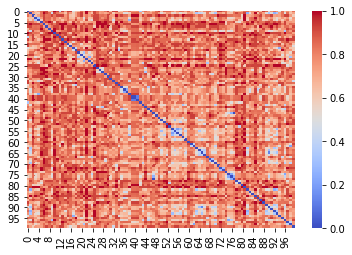

In [10]:
sns.heatmap(Y[:100, :100], cmap='coolwarm')

Sort each row by similarity (0 on the left, 1 on the right), and return the column j of each of those values

In [25]:
sort_Y = Y.argsort(axis=1)

Take the first two columns of the above (or, the reference project and its most similar project). Sort the n x 2 matrix on each row, putting the smaller number first. Get rid of any duplicates:

if the n x 2 matrix has both (0, 1234) and (1234, 0), once sorted they show up as (0, 1234) and (0, 1234) and we remove one of those instances.

In [39]:
unique_sort_Y = np.unique(np.sort(sort_Y[:, 0:2], axis=1), axis=0)

X-axis is the reference project "ID" (just the project's i value in the similarity matrix), y-axis is the similar project "ID" (the project's i value in the sim matrix too). Each dot represents a pair of similar projects. It should appear roughly uniform. Only upper triangle reported because we removed dups.

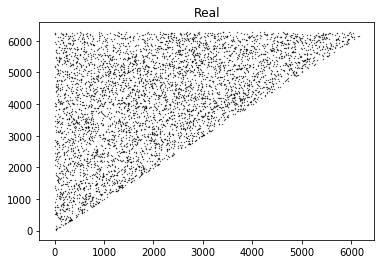

In [40]:
plt.title('Real')
plt.scatter(unique_sort_Y[:, 0], unique_sort_Y[:, 1], c='k', s=0.1)

Get actual project IDs from the merged project dataframe made in Cell 4.

In [41]:
ds = []
indices = []

for pair in unique_sort_Y:
    ds.append(Y[pair[0], pair[1]])
    
    ixs = num_mat.iloc[[pair[0], pair[1]], :].index
    indices.append(list(ixs))
    
    if pair[0] < 2:
        print('distance: {}\t({},{})'.format(Y[pair[0], pair[1]], pair[0], pair[1]))
        print(cat_break.loc[ixs])

indices = np.array(indices)

distance: 0.125	(0,4869)
                            project_id                         school_id  \
0     49aec114dc7faf5ee2e4af2e6e20f034  d79932de9de06c0f21435de838acf31e   
7803  363158fc0881aa06ec9e812ad1ccafd8  232fb09b191947943f4f832b7c8d093f   

                            teacher_id                             cat_tree  \
0     513ec0c4be506c354f179d48f0cf10ca  Literacy & Language, Math & Science   
7803  9de05197dd361da330f070fc84fd879e                  Literacy & Language   

      grade_level              resource_cat    cost  status  prefix  \
0               2  Educational Kits & Games  528.84       1       1   
7803            2                Technology  592.48       1       1   

                           school_name  metro_type  free_lunch school_state  \
0      Prairie Winds Elementary School           2        34.0     Colorado   
7803  Evelyn Stuckey Elementary School           2        31.0       Nevada   

      school_zip  school_city school_county             

Mean Jaccard similarity coefficient: 0.217


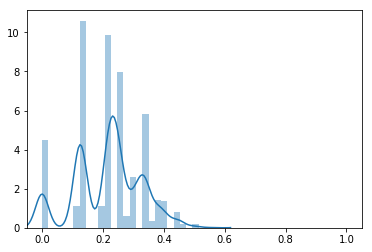

In [42]:
sns.distplot(ds, kde=True)
plt.xlim([-0.05, 1.05])
print('Mean Jaccard similarity coefficient: {:.3f}'.format(np.array(ds).mean()))

Mean Jaccard similarity coefficient is 0.217, on a scale from 0 to 1. Below that is a distribution of the similarity scores found by the algorithm.

/Users/alex/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: overflow encountered in ubyte_scalars
/Users/alex/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:32: RuntimeWarning: overflow encountered in ubyte_scalars
  return umr_sum(a, axis, dtype, out, keepdims)


0.58355014527982985

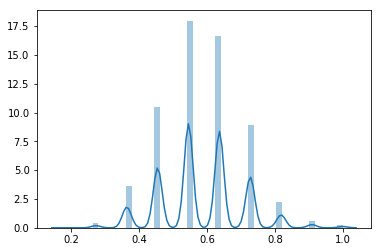

In [80]:
def fitnessTest(selection):
#     print(selection)
    score = 0
    
    score += 1 if selection.iloc[0, 3] == selection.iloc[1, 3] else 0 # cat_tree
    score += 1 if selection.iloc[0, 4] == selection.iloc[1, 4] else 0 # grade_level
    score += 1 if selection.iloc[0, 5] == selection.iloc[1, 5] else 0 # resource_cat
    score += 1 if np.absolute(selection.iloc[0, 6] - selection.iloc[1, 6]) <= 50 else 0 # cost
    score += 1 if selection.iloc[0, 7] == selection.iloc[1, 7] else 0 # status
    score += 1 if selection.iloc[0, 8] == selection.iloc[1, 8] else 0 # prefix
    score += 1 if selection.iloc[0, 10] == selection.iloc[1, 10] else 0 # metro_type
    score += 1 if np.absolute(selection.iloc[0, 11] - selection.iloc[1, 11]) <= 10 else 0 # free_lunch
    score += 1 if np.absolute(selection.iloc[0, 13] - selection.iloc[1, 13]) <= 500 else 0 # school_zip
    score += 1 if selection.iloc[0, 16] == selection.iloc[1, 16] else 0 # school_district
    
    a = selection.iloc[0, 19:].values
    b = selection.iloc[1, 19:].values
    score += 1 if np.absolute(b-a).sum() < 2 else 0 # subcats, must have at least one overlap subcat

    return score

results = []
for ixs in indices:
    results.append(fitnessTest(cat_break.loc[ixs]) / 11) # divide by 11 to normalize for maximum # of points

sns.distplot(results)
np.array(results).mean()

Above is the average fitness score for all pairs of similar projects. Below that is a distribution of fitness scores. We could do some simulation/test to see if 0.584 is significantly above chance or not.

Below is a search tree to find links of similar projects. Of 5000 indices, the longest chain of similar projects (i.e. the transitive property of similar projects... a=b, and b=c, thus a=c). Printed are siz projects that are found to be about the same based on this idea.

In [78]:
s_i = np.sort(indices, axis=1)

def search(link):
    try:
        nxt = s_i[s_i[:, 0] == link[-1]][0][1]
    except IndexError:
        return link
            
    if len(link) == 10:
        return link
    else:
        return search(np.append(link, nxt))
    
ixs = None

# loop through indices 0-4999 and search for trees that link from that index

for i in range(5000):
    try:
        ixs = search(s_i[s_i[:, 0] == i][0])
    except IndexError:
        continue
    
    if len(ixs) > 5:
        print('found 6 or more similar projects!')
        break

found 6 or more similar projects!


In [79]:
cat_break.loc[ixs]

,project_id,school_id,teacher_id,cat_tree,grade_level,resource_cat,cost,status,prefix,school_name,metro_type,free_lunch,school_state,school_zip,school_city,school_county,school_district,subcat_first,subcat_second,s_Applied Sciences,s_Care & Hunger,s_Character Education,s_Civics & Government,s_College & Career Prep,s_Community Service,s_ESL,s_Early Development,s_Economics,s_Environmental Science,s_Extracurricular,s_Financial Literacy,s_Foreign Languages,s_Gym & Fitness,s_Health & Life Science,s_Health & Wellness,s_History & Geography,s_Literacy,s_Literature & Writing,s_Mathematics,s_Music,s_Nutrition Education,s_Other,s_Parent Involvement,s_Performing Arts,s_Social Sciences,s_Special Needs,s_Team Sports,s_Visual Arts,s_Warmth
745,721e4bfea105165258f5a63f8e3ef8e5,f452efc890490f0558efb09d505af19d,7ea1dedfb150065fd3747670df3f5c0d,"Math & Science, Music & The Arts",6,Technology,1067.66,1,2,Salt Lake Center-Science Education,3,51.0,Utah,84116,Salt Lake City,Salt Lake,Salt Lake City School District,Applied Sciences,Visual Arts,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2396,b30d57fba4a8d3efc5205bd9c3b74f97,c36d914f8c0170b55c2bc2c8afdd182b,61956ec2568cdc0309ff2574ffacf4c5,Music & The Arts,6,Technology,537.07,1,2,North Middle School,3,67.0,Colorado,80903,Colorado Spgs,El Paso,Colorado Springs Sch Dist 11,Visual Arts,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3412,27c059018407a056890f176e80df5c87,b6327d18a6ef243558fc610d1e987b43,cb39f3311dd0f1fd917ec71fb5c7fe7a,"Applied Learning, Music & The Arts",6,Technology,678.09,1,2,Sun Ridge Middle School,3,61.0,Texas,79938,El Paso,El Paso,Socorro Ind School Dist,Community Service,Visual Arts,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
5583,8dccd830a69bc0f9adb03724454b2d1b,0057a88739632e1ea4e11b17228d24b1,31cedcf8f91bde095c3ab5556ed16e80,Music & The Arts,6,Supplies,690.60,1,1,Whittier Middle School,3,62.0,South Dakota,57103,Sioux Falls,Minnehaha,Sioux Falls School Dist 49-5,Visual Arts,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
7167,790d67e3d30045b3c66d13781bb67d50,eeedf6c9c5a9dc5eec1e2fe7ccbda4e1,5f44984ea1e512e9c21cc8327fdbcfa6,"Math & Science, Music & The Arts",6,Technology,691.28,1,1,Lane Technical College Prep High School,3,58.0,Illinois,60618,Chicago,Cook,Chicago Psd-Network 4,Applied Sciences,Visual Arts,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
9020,943a818056aeffb2ced3222f27a9ae70,74a298b81e6ea8939a92124b0b46e81a,0a9688d9194d2b7c51e2c87a12ef9ca3,Math & Science,6,Technology,512.61,1,1,North Little Rock Middle School,3,62.0,Arkansas,72116,N Little Rock,Pulaski,North Little Rock School Dist,Applied Sciences,NaN,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
